# Importing necessary Libraries


In [566]:
import pandas as pd
import numpy as np
import nltk
import re
import torch
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, hamming_loss, roc_auc_score, precision_score, recall_score, f1_score, classification_report
import joblib




# Downloading stopwords for text processing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samiyasarwar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samiyasarwar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/samiyasarwar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Loading the Dataset

In [567]:
df = pd.read_csv("goemotions.csv")

# Exploring the dataset to understand it properly

In [568]:
# Checking the number of Rows and Columns
df.shape

(211225, 37)

In [569]:
# the first few rows
df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [570]:
df.columns

Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [571]:
# Checking Columns data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  

In [572]:
# summary statistic
df.describe()

,created_utc,rater_id,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
count,2.112250e+05,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,...,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000
mean,1.547659e+09,37.619742,0.081103,0.043768,0.038272,0.064472,0.083418,0.028401,0.034840,0.045885,...,0.038779,0.008569,0.041259,0.006164,0.041591,0.006102,0.011954,0.031994,0.026105,0.261797
std,7.696842e+05,23.070528,0.272994,0.204580,0.191853,0.245592,0.276514,0.166116,0.183374,0.209236,...,0.193067,0.092172,0.198890,0.078269,0.199653,0.077880,0.108679,0.175985,0.159448,0.439614
min,1.546301e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.546993e+09,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.547664e+09,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.548320e+09,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.548979e+09,81.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Cleaning and Preprocessing

In [573]:
# Checking for missing values
df.isnull().sum()

text                    0
id                      0
author                  0
subreddit               0
link_id                 0
parent_id               0
created_utc             0
rater_id                0
example_very_unclear    0
admiration              0
amusement               0
anger                   0
annoyance               0
approval                0
caring                  0
confusion               0
curiosity               0
desire                  0
disappointment          0
disapproval             0
disgust                 0
embarrassment           0
excitement              0
fear                    0
gratitude               0
grief                   0
joy                     0
love                    0
nervousness             0
optimism                0
pride                   0
realization             0
relief                  0
remorse                 0
sadness                 0
surprise                0
neutral                 0
dtype: int64

In [574]:
# Checking for duplicates in entire dataset
num_duplicates = df.duplicated().sum()
num_duplicates

0

In [575]:
# Checking number of duplicates in text column
num_duplicates_text = df.duplicated(subset=['text']).sum()
num_duplicates_text

153493

In [576]:
# Checking duplicate rows based on text
num_duplicates_text = df[df.duplicated(subset=['text'], keep=False)] 

num_duplicates_text

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,Everyone likes [NAME].,ee6pagw,Senshado,heroesofthestorm,t3_agjf24,t3_agjf24,1.547634e+09,16,False,0,...,1,0,0,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,ef28nod,5inchloser,nottheonion,t3_ak26t3,t3_ak26t3,1.548553e+09,15,False,0,...,0,0,0,0,0,0,0,0,0,0
211222,That looks amazing,ee8hse1,springt1me,shittyfoodporn,t3_agrnqb,t3_agrnqb,1.547684e+09,70,False,1,...,0,0,0,0,0,0,0,0,0,0
211223,The FDA has plenty to criticize. But like here...,edrhoxh,enamedata,medicine,t3_aejqzd,t1_edrgdtx,1.547169e+09,4,False,0,...,0,0,0,0,0,0,0,0,0,0


In [577]:
# Defining text preprocessing function
def clean_text(text):
    text = text.lower()  
    text = re.sub(r'\W', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    text = ' '.join([word for word in text.split() if word not in stop_words])  
    return text


In [578]:
# Applying preprocessing
df['clean_text'] = df['text'].apply(clean_text)

In [579]:
# Checking for empty texts
empty_texts = df[df['clean_text'].str.strip() == '']
len(empty_texts)

513

In [580]:
# Checking for very short texts
short_texts = df[df['clean_text'].str.split().str.len() <= 2]
len(short_texts)

25572

In [581]:
# Inspecting empty texts
empty_texts = df[df['clean_text'].str.strip() == '']
empty_texts.sample(5)

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,clean_text
14399,how about now,eewwe5v,RJ_Ramrod,saltierthancrait,t3_ajmgp9,t1_eewrop9,1.548408e+09,39,False,0,...,0,0,0,0,0,0,0,0,1,
14533,I did that.,edszuw3,notaeasyday,AnimalsBeingJerks,t3_aetxgs,t1_edszeq1,1.547215e+09,6,False,0,...,0,0,0,0,0,0,0,0,1,
24125,The what now?,ed3u5xj,estomagordo,hockey,t3_abxmbw,t1_ed3txro,1.546466e+09,61,True,0,...,0,0,0,0,0,0,0,0,0,
143937,.. for now,eeo7nr2,Its-very-that,gay_irl,t3_aih0ob,t1_eeo1o5b,1.548134e+09,4,False,0,...,0,0,0,0,0,0,0,0,1,
42738,no it wouldn't,eer86hq,saturnine_shine,syriancivilwar,t3_aityrw,t1_eer736v,1.548234e+09,25,True,0,...,0,0,0,0,0,0,0,0,0,


In [582]:
# Inspecting very short texts
very_short_texts = df[df['clean_text'].str.split().str.len() <= 2]
very_short_texts.sample(5)

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,clean_text
173924,I see. Thanks again.,edbrmlc,MrTotoro1,AskALiberal,t3_acwqmu,t1_edbr69z,1.546721e+09,23,False,0,...,0,0,0,0,0,0,0,0,0,see thanks
9304,Wait.... What??!,ed6tvft,SacredGeometry25,Tinder,t3_aca6zc,t1_ed6rvha,1.546562e+09,49,False,0,...,0,0,0,0,0,0,0,0,1,wait
16254,"""Eh"" Love it.",eez3shh,waldo06,MurderedByWords,t3_ajnr27,t3_ajnr27,1.548462e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,eh love
184085,he's obviously helping,eepk3ng,wiscokev,dogswithjobs,t3_aint3x,t3_aint3x,1.548183e+09,55,False,0,...,0,0,0,0,0,0,0,0,1,obviously helping
155761,Go [NAME]!,ee8z3wj,FunFactress,My600lbLife,t3_agkpbj,t3_agkpbj,1.547697e+09,46,False,0,...,0,0,0,0,0,0,0,0,1,go name


In [583]:
# Removing empty texts
df = df[df['clean_text'].str.strip() != '']

len(df[df['clean_text'].str.strip() == ''])

0

In [584]:
# Removing very short texts
df = df[df['clean_text'].str.split().str.len() > 2]

len(df[df['clean_text'].str.split().str.len() <= 2])

0

# varifying cleaned dataset

In [585]:
df.shape

(185653, 38)

In [586]:
df.columns

Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral', 'clean_text'],
      dtype='object')

# Converting text data into numerical format

In [587]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features for efficiency
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

In [588]:
joblib.dump(tfidf_vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [589]:
# Dimensionality Reduction for faster model train
svd_model = TruncatedSVD(n_components=300)  # Reduced to 300 features
X_svd = svd_model.fit_transform(X_tfidf)


In [590]:
joblib.dump(svd_model, 'svd.pkl')               


['svd.pkl']

In [591]:
# Converting to DataFrame
processed_df = pd.DataFrame(X_svd)

# Saving processed features
processed_df.to_csv("cleaned_and_preprocessed_goemotions.csv", index=False)


In [592]:
emotion_columns = [ 'admiration',
       'amusement', 'anger', 'annoyance', 'caring', 'confusion',
       'curiosity', 'disappointment', 'disgust',
       'embarrassment', 'excitement', 'fear', 'grief', 'joy',
       'love', 'nervousness', 'pride',
       'remorse', 'sadness', 'surprise', 'neutral',]


In [593]:
# Checking the distribution of each emotion column
for emotion in emotion_columns:
    f"{emotion}: {df[emotion].sum()}"

In [594]:
# Defining the target variable for multi-label
y = df[emotion_columns]
y

,admiration,amusement,anger,annoyance,caring,confusion,curiosity,disappointment,disgust,embarrassment,...,fear,grief,joy,love,nervousness,pride,remorse,sadness,surprise,neutral
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211219,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
211220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
211221,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [595]:
y.columns

Index(['admiration', 'amusement', 'anger', 'annoyance', 'caring', 'confusion',
       'curiosity', 'disappointment', 'disgust', 'embarrassment', 'excitement',
       'fear', 'grief', 'joy', 'love', 'nervousness', 'pride', 'remorse',
       'sadness', 'surprise', 'neutral'],
      dtype='object')

In [596]:
non_zero_mask = y.sum(axis=1) > 0
X_svd_filtered = X_svd[non_zero_mask]
y_filtered = y[non_zero_mask]


In [597]:
# Find index of 'neutral' label
neutral_index = emotion_columns.index('neutral')

# Filter out samples that only have 'neutral' and no other emotion
only_neutral_mask = (y_filtered.iloc[:, neutral_index] == 1) & (y_filtered.sum(axis=1) == 1)

# Keep samples that are not only neutral
X_svd_final = X_svd_filtered[~only_neutral_mask]
y_final = y_filtered[~only_neutral_mask]

print("Remaining samples:", X_svd_final.shape[0])


Remaining samples: 98455


In [598]:
from sklearn.model_selection import train_test_split

# Use final filtered data (after removing only-neutral samples)
X_train, X_test, y_train, y_test = train_test_split(X_svd_final, y_final, test_size=0.2, random_state=42)

# Check the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (78764, 300)
X_test shape: (19691, 300)
y_train shape: (78764, 21)
y_test shape: (19691, 21)


In [599]:
import numpy as np

# Check the distribution of labels
print("Number of training samples:", y_train.shape[0])

# Pick the first row using `.iloc` since it's a DataFrame
print("Number of labels in first sample:", np.sum(y_train.iloc[0]))

# Count samples that have at least one label
non_zero_rows = y_train.sum(axis=1)
print("Samples with at least one label:", (non_zero_rows > 0).sum())
print("Samples with all-zero labels:", (non_zero_rows == 0).sum())

# Check total count per emotion label
label_sums = y_train.sum(axis=0)
print("Total counts per emotion label in training set:")
for idx, (emotion, count) in enumerate(label_sums.items()):
    print(f"{idx:2d}: {emotion:15s} → {int(count)}")


Number of training samples: 78764
Number of labels in first sample: 2
Samples with at least one label: 78764
Samples with all-zero labels: 0
Total counts per emotion label in training set:
 0: admiration      → 12032
 1: amusement       → 6717
 2: anger           → 5558
 3: annoyance       → 10028
 4: caring          → 4402
 5: confusion       → 5263
 6: curiosity       → 6810
 7: disappointment  → 6287
 8: disgust         → 3838
 9: embarrassment   → 1835
10: excitement      → 3924
11: fear            → 2252
12: grief           → 477
13: joy             → 5672
14: love            → 5716
15: nervousness     → 1331
16: pride           → 937
17: remorse         → 1912
18: sadness         → 4879
19: surprise        → 3903
20: neutral         → 0


In [600]:

log_reg = OneVsRestClassifier(LogisticRegression())

In [601]:
# Training the model
log_reg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label not 20 is present in all training examples.
  warnings.warn(


OneVsRestClassifier(estimator=LogisticRegression())

In [613]:
from sklearn.metrics import accuracy_score, hamming_loss, classification_report

# ✅ Predict on the correct test set
y_pred_log = log_reg.predict(X_test)

# ✅ Evaluate performance
print("✅ Accuracy:", accuracy_score(y_test, y_pred_log))
print("✅ Hamming Loss:", hamming_loss(y_test, y_pred_log))
print("✅ Classification Report:")
print(classification_report(y_test, y_pred_log, target_names=emotion_columns, zero_division=0))


✅ Accuracy: 0.1287898024478188
✅ Hamming Loss: 0.05240731201830181
✅ Classification Report:
                precision    recall  f1-score   support

    admiration       0.71      0.34      0.46      2929
     amusement       0.72      0.45      0.55      1693
         anger       0.55      0.08      0.14      1399
     annoyance       0.46      0.02      0.03      2523
        caring       0.61      0.06      0.11      1057
     confusion       0.50      0.03      0.05      1330
     curiosity       0.67      0.02      0.04      1630
disappointment       0.33      0.00      0.00      1616
       disgust       0.44      0.04      0.08      1015
 embarrassment       0.00      0.00      0.00       478
    excitement       0.43      0.02      0.04       959
          fear       0.50      0.01      0.03       594
         grief       0.00      0.00      0.00       130
           joy       0.57      0.16      0.25      1466
          love       0.72      0.44      0.55      1393
   nervousn

# Evaluation Model Performance

In [603]:
accuracy_score(y_test, y_pred_log)
hamming_loss(y_test, y_pred_log)
classification_report(y_test, y_pred_log, target_names=emotion_columns)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pac

'                precision    recall  f1-score   support\n\n    admiration       0.71      0.34      0.46      2929\n     amusement       0.72      0.45      0.55      1693\n         anger       0.55      0.08      0.14      1399\n     annoyance       0.46      0.02      0.03      2523\n        caring       0.61      0.06      0.11      1057\n     confusion       0.50      0.03      0.05      1330\n     curiosity       0.67      0.02      0.04      1630\ndisappointment       0.33      0.00      0.00      1616\n       disgust       0.44      0.04      0.08      1015\n embarrassment       0.00      0.00      0.00       478\n    excitement       0.43      0.02      0.04       959\n          fear       0.50      0.01      0.03       594\n         grief       0.00      0.00      0.00       130\n           joy       0.57      0.16      0.25      1466\n          love       0.72      0.44      0.55      1393\n   nervousness       0.00      0.00      0.00       322\n         pride       0.00   

# Creating confusion matrice for each emotions

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


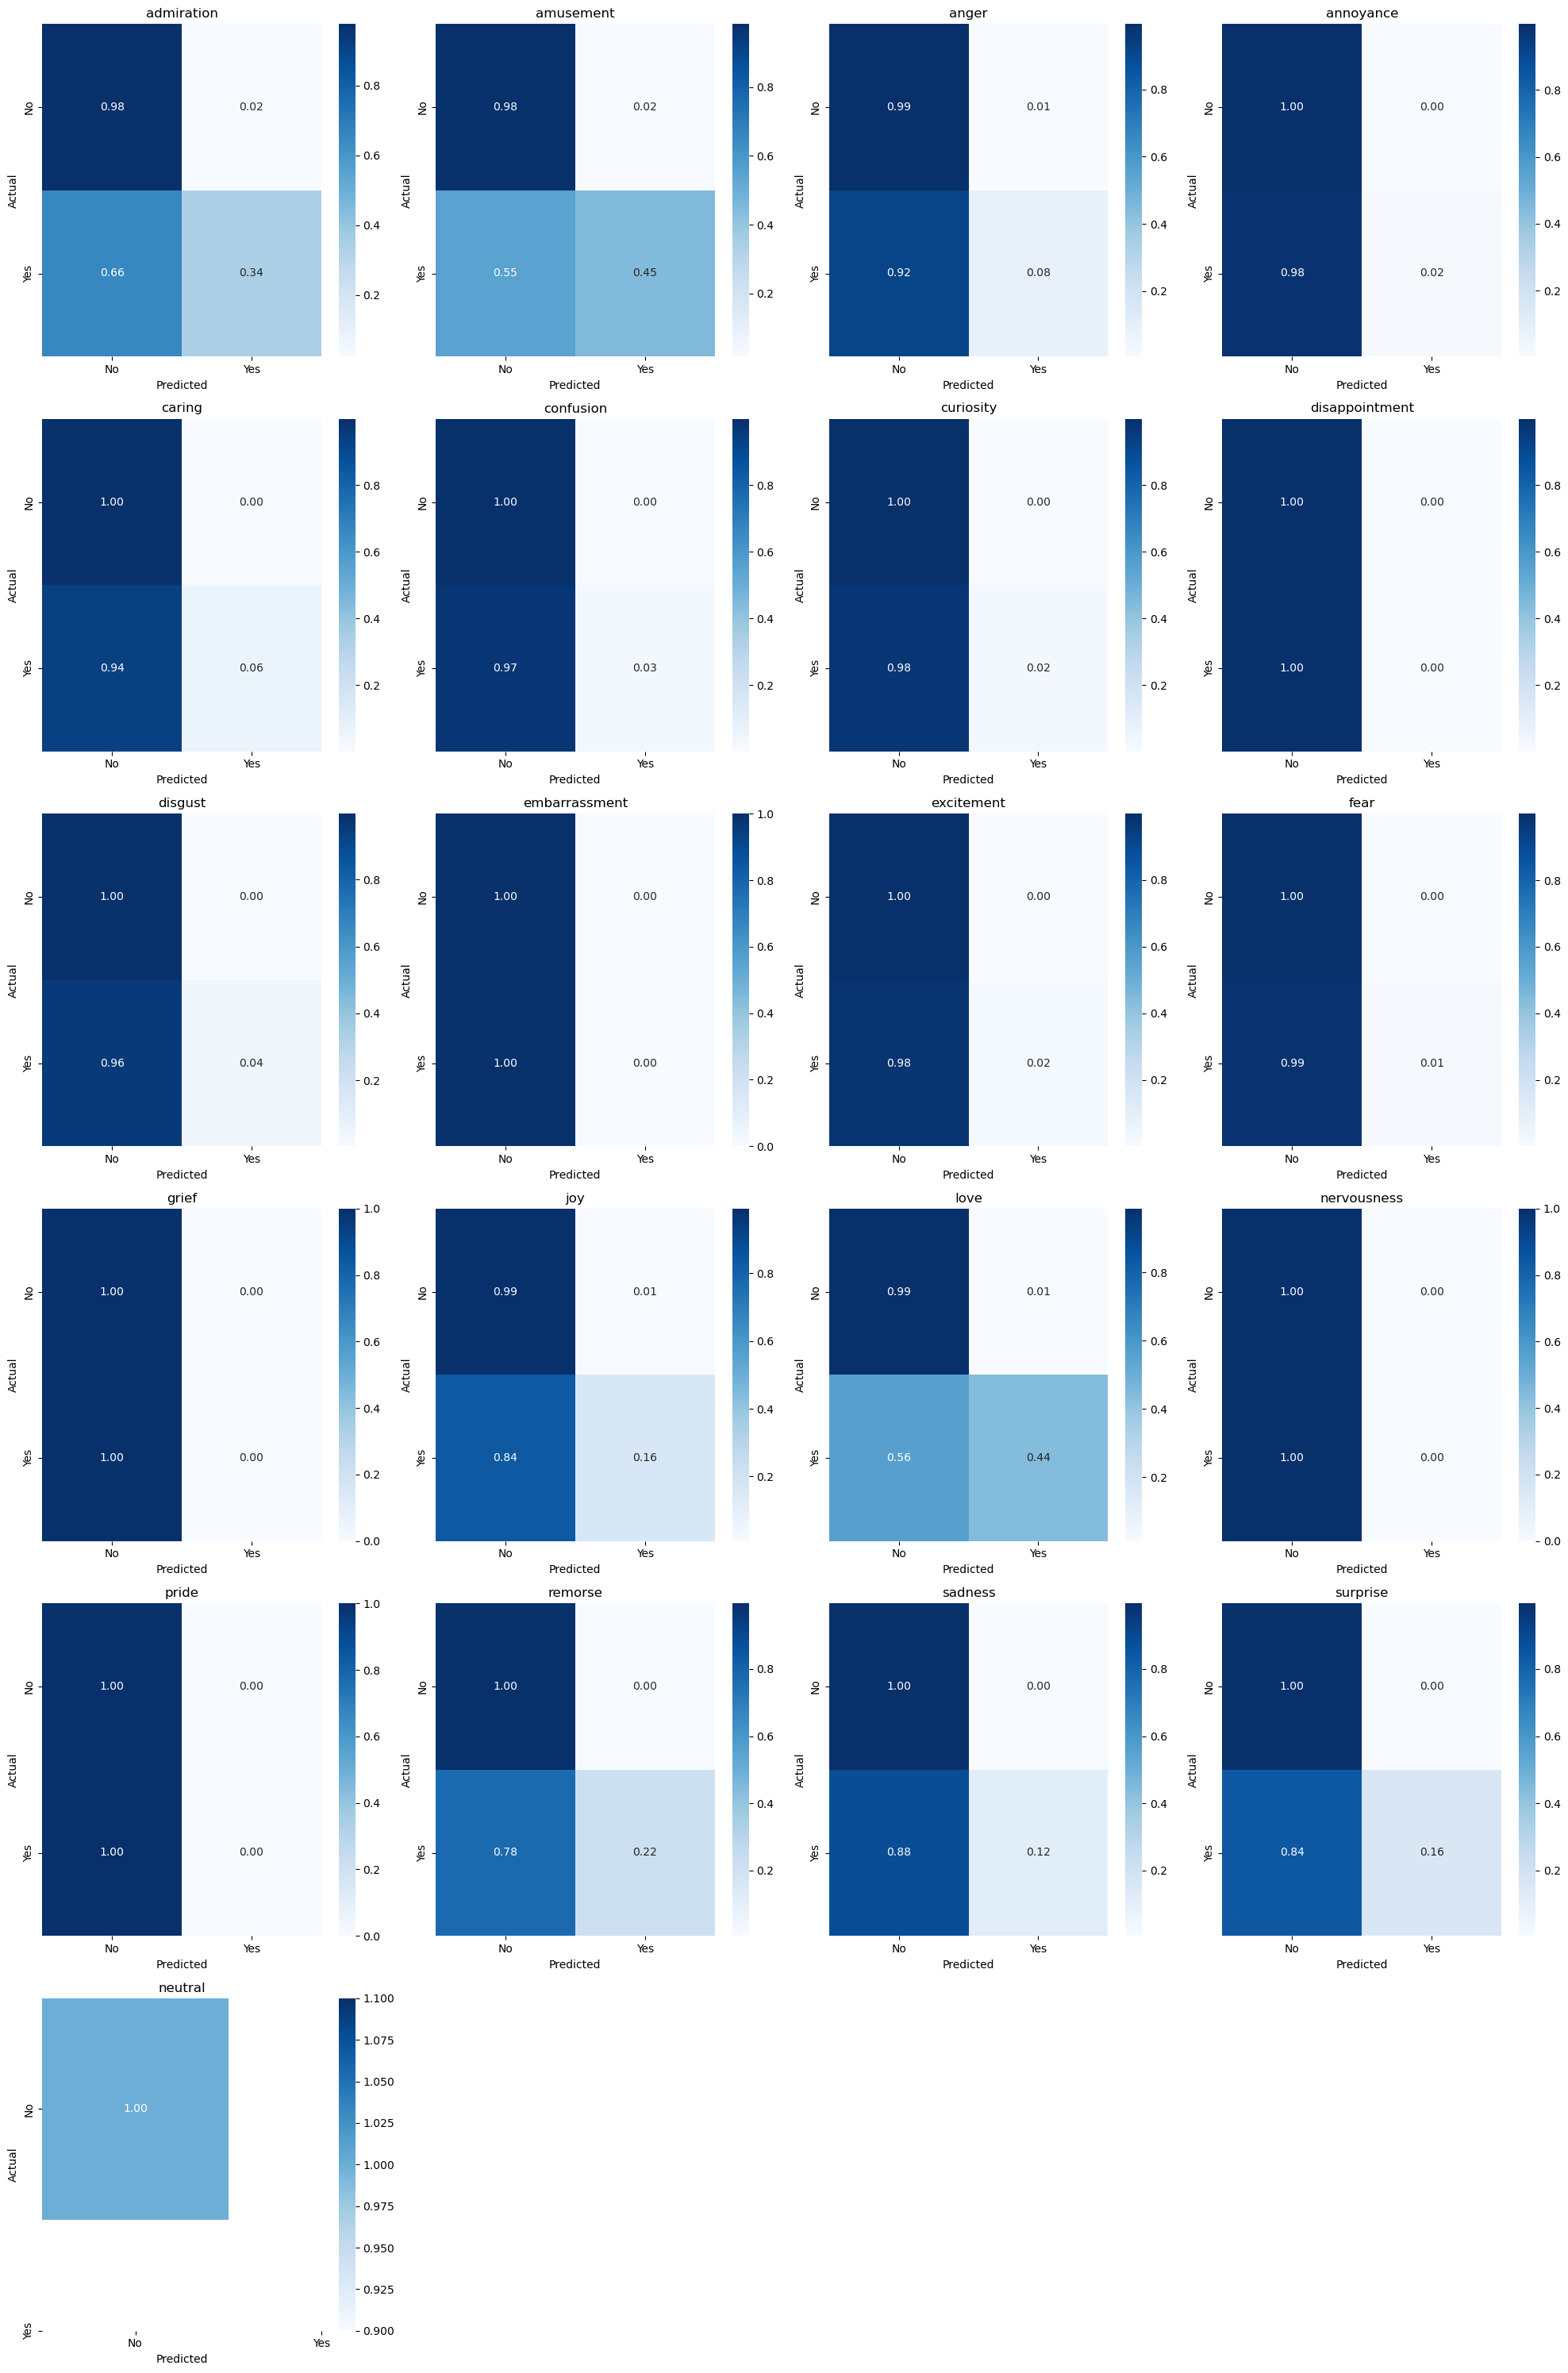

In [604]:

n_emotions = len(emotion_columns)
n_cols = 4 
n_rows = int(np.ceil(n_emotions / n_cols)) 

plt.figure(figsize=(20, 5 * n_rows))

for i, emotion in enumerate(emotion_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    
    cm = confusion_matrix(y_test.iloc[:, i], y_pred_log[:, i])
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    
    plt.title(f"{emotion}", fontsize=12)
    plt.xlabel("Predicted", fontsize=10)
    plt.ylabel("Actual", fontsize=10)

plt.tight_layout()
plt.show()

Interpretetion of the above confusion metrice:this image provides a comprehensive visualization of the multi-label classification model's performance for each emotion, allowing for a detailed understanding of its strengths and weaknesses.The model generally performs well for most emotions, with high values on the diagonal (TN and TP) and low values on the off-diagonal (FP and FN).

# Calibration curve for each emotion

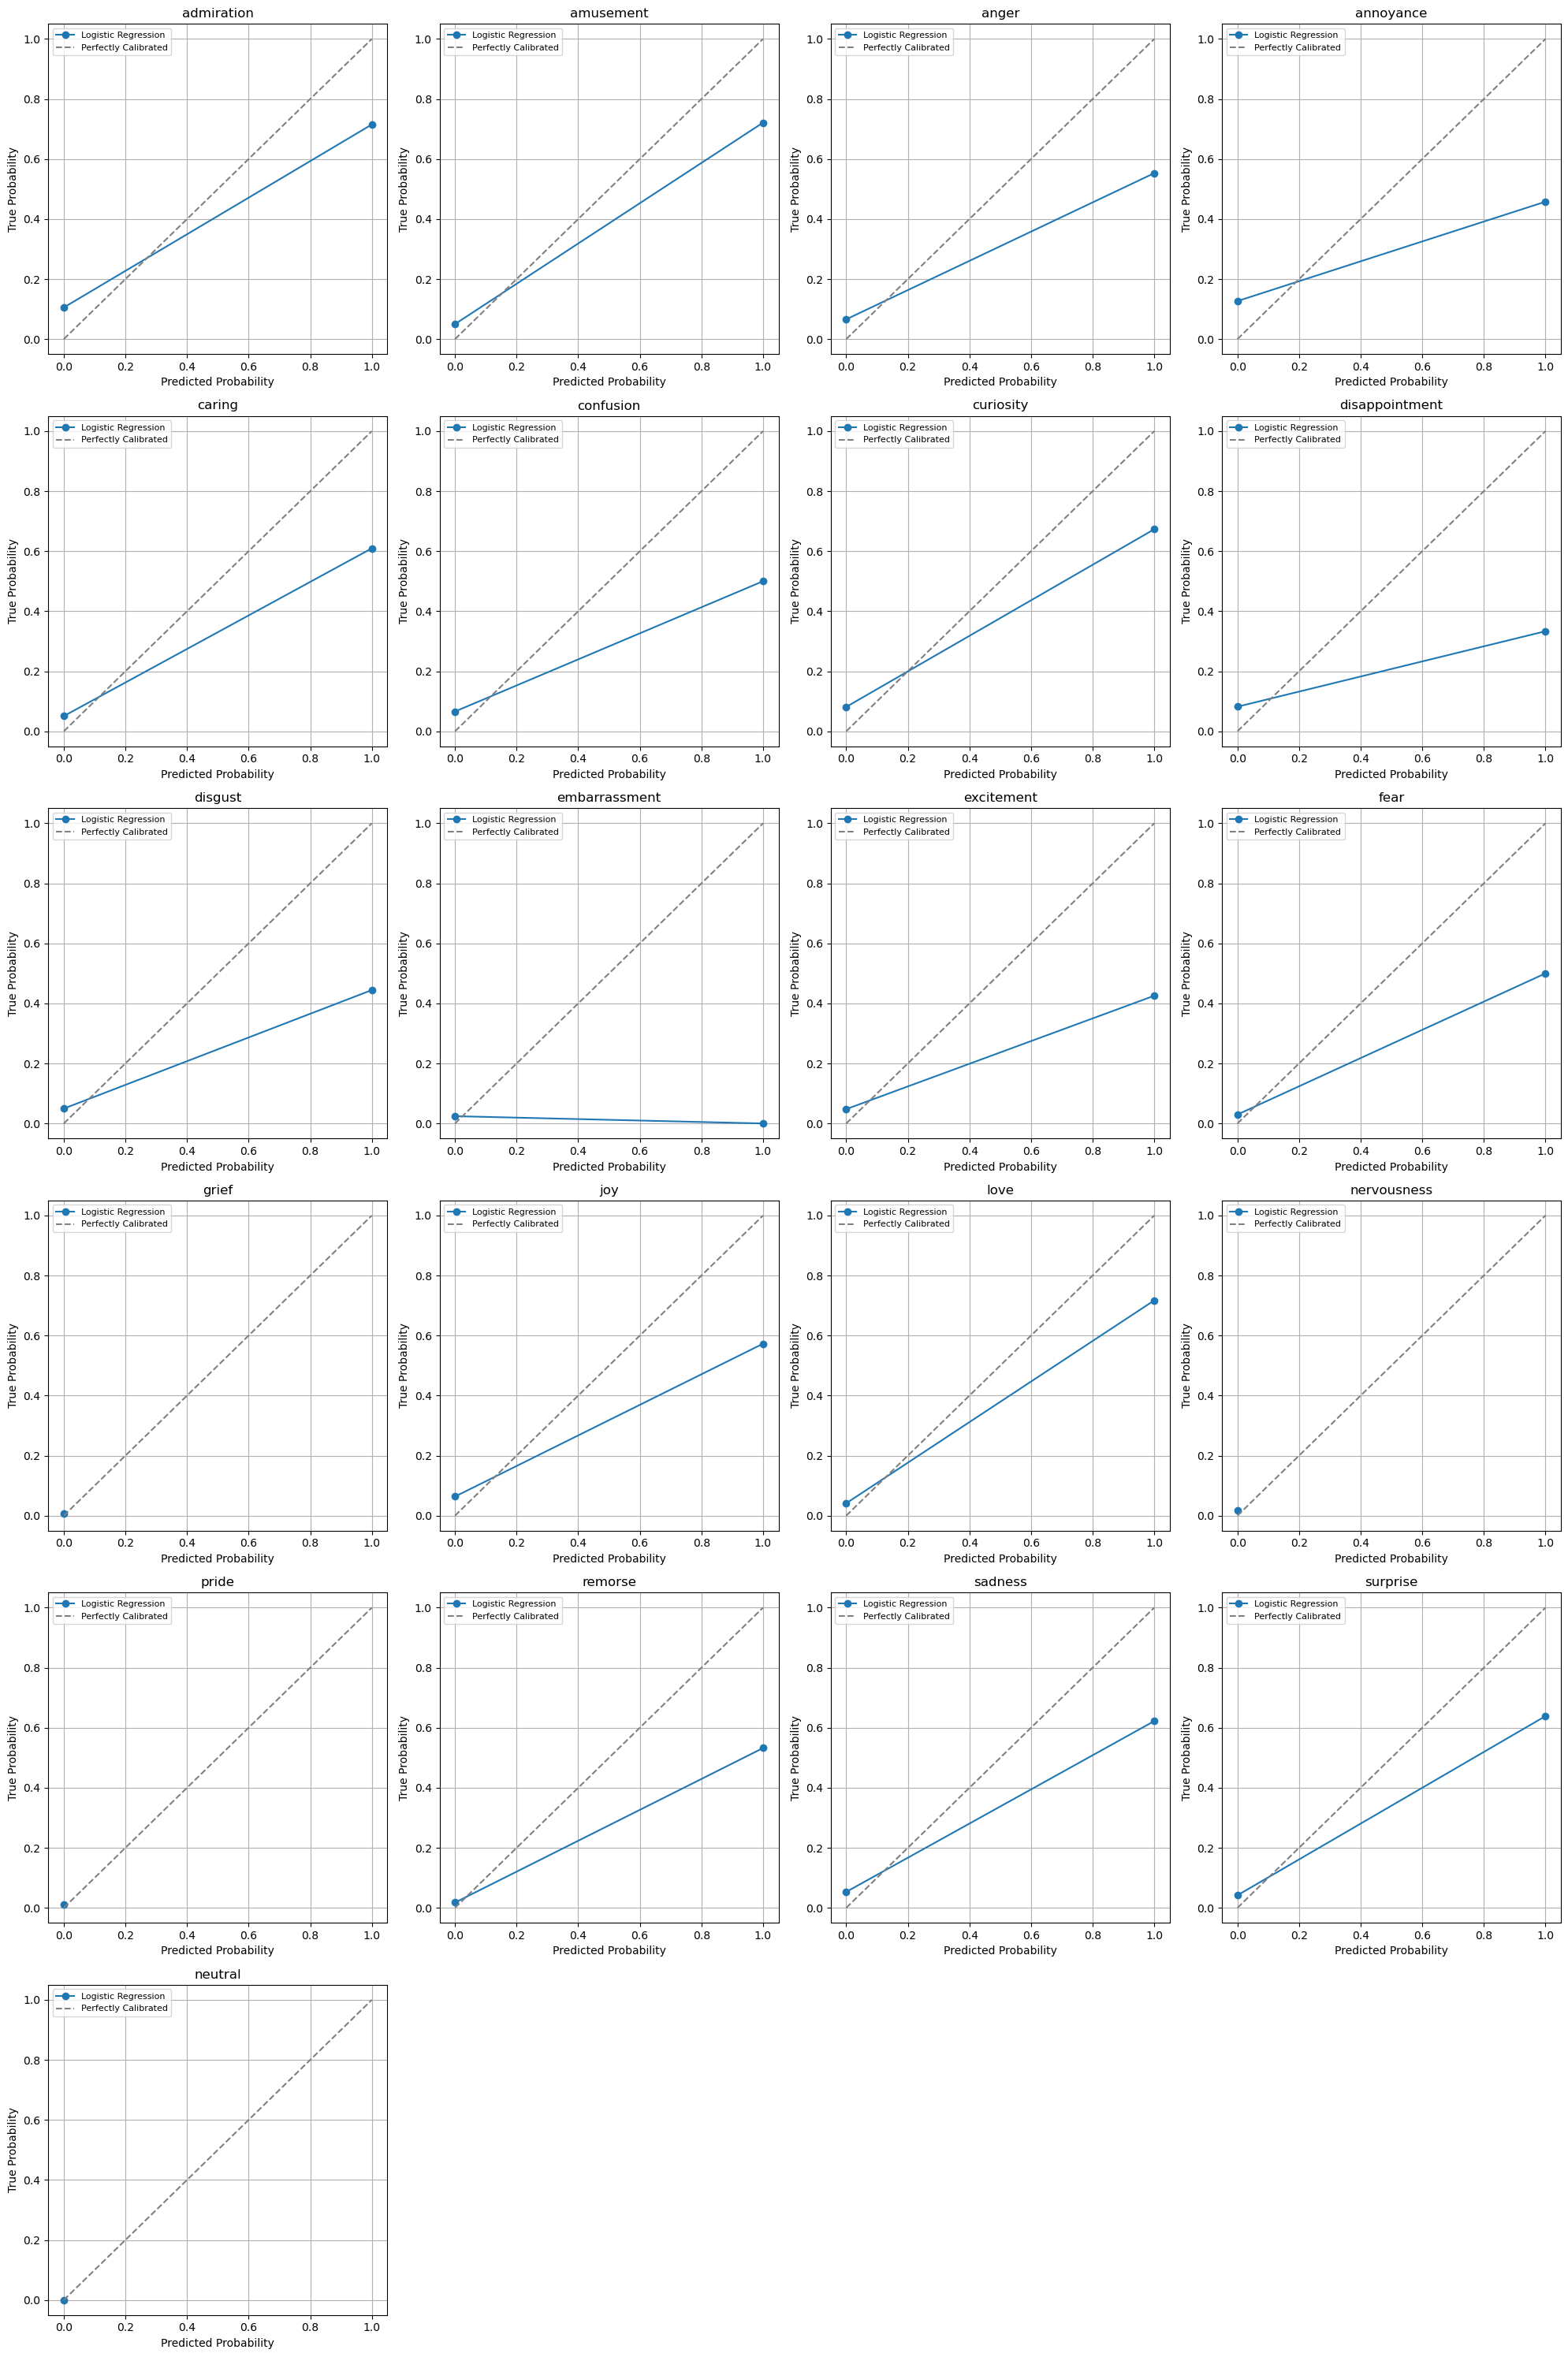

In [605]:

n_emotions = len(emotion_columns)
n_cols = 4 
n_rows = int(np.ceil(n_emotions / n_cols))

plt.figure(figsize=(20, 5 * n_rows))

for i, emotion in enumerate(emotion_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    
    prob_true, prob_pred = calibration_curve(y_test.iloc[:, i], y_pred_log[:, i], n_bins=10)
    
    plt.plot(prob_pred, prob_true, marker='o', label="Logistic Regression")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfectly Calibrated")
    
    plt.title(f"{emotion}", fontsize=12)
    plt.xlabel("Predicted Probability", fontsize=10)
    plt.ylabel("True Probability", fontsize=10)
    plt.legend(loc="upper left", fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.show()

Interpretation of the above Calibration curve: this image reveals that the multi-label classification model's predicted probabilities are generally overconfident across various emotions.The consistent deviation from the diagonal suggests that the model's predicted probabilities are not well-calibrated.

# Precision Recall curve

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


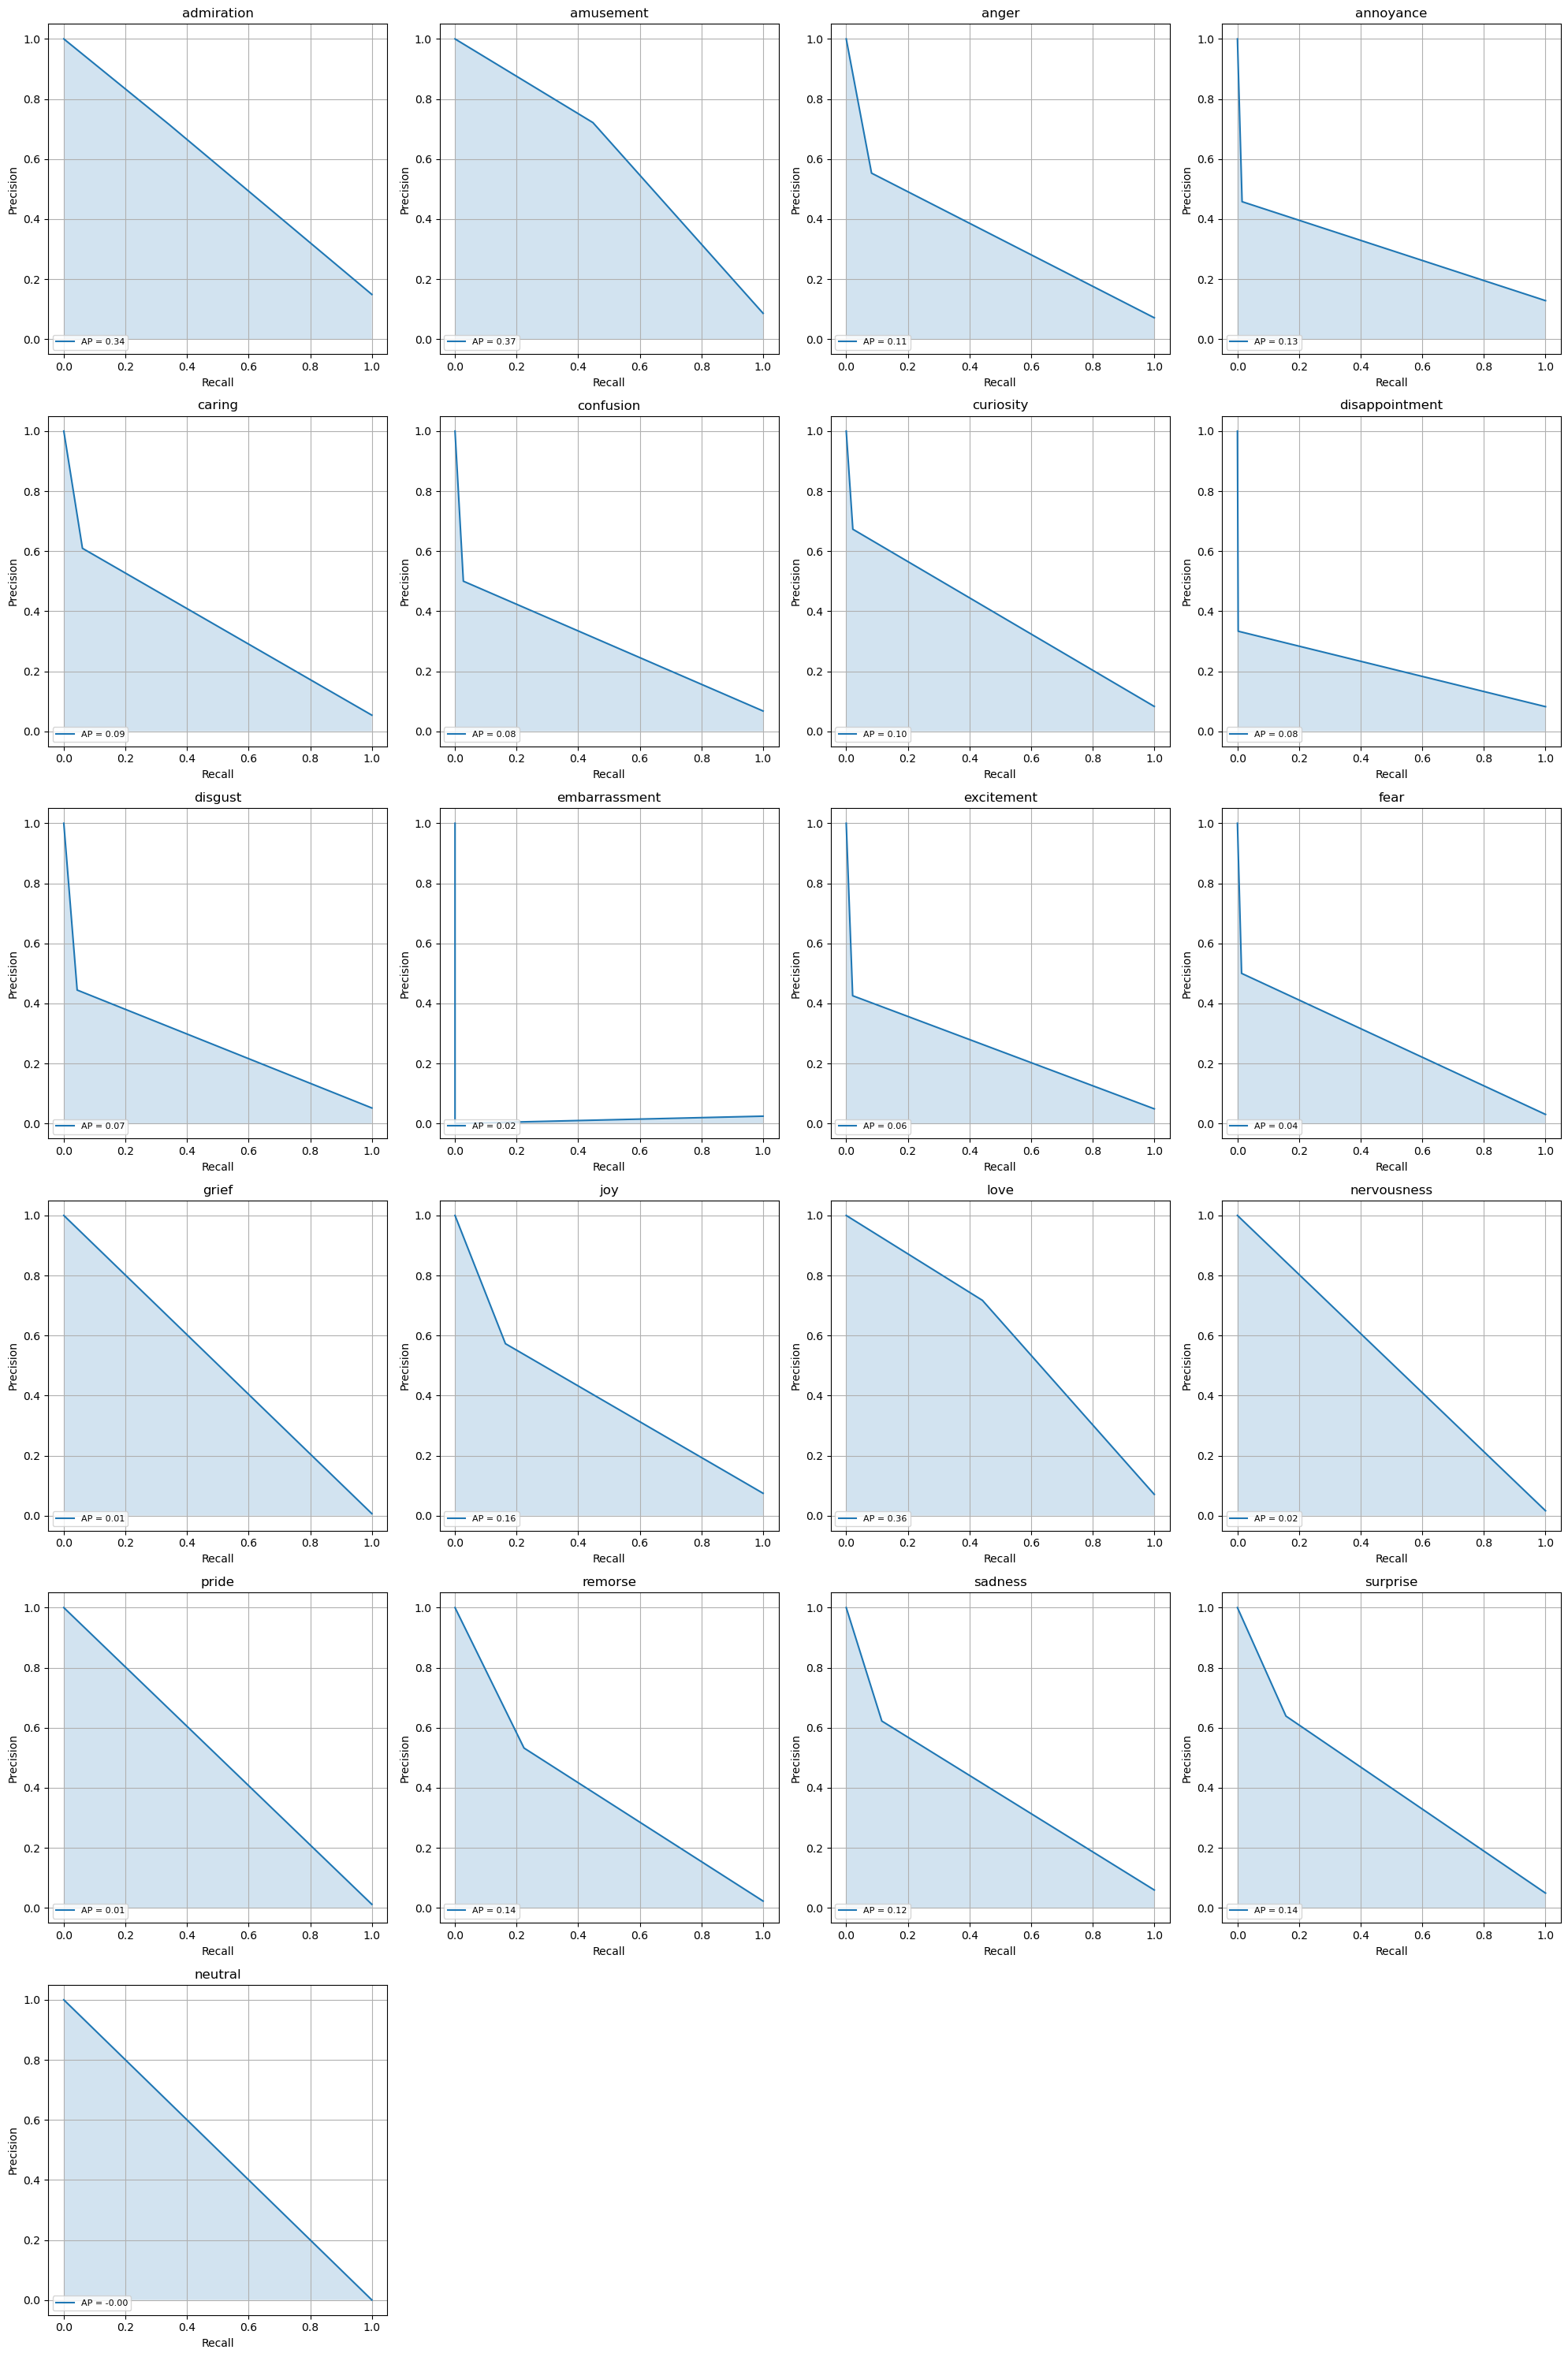

In [606]:

n_emotions = len(emotion_columns)
n_cols = 4  
n_rows = int(np.ceil(n_emotions / n_cols))  

plt.figure(figsize=(20, 5 * n_rows))

for i, emotion in enumerate(emotion_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    
    precision, recall, _ = precision_recall_curve(y_test.iloc[:, i], y_pred_log[:, i])
    average_precision = average_precision_score(y_test.iloc[:, i], y_pred_log[:, i])
    
    plt.plot(recall, precision, label=f"AP = {average_precision:.2f}")
    plt.fill_between(recall, precision, alpha=0.2)
    
    plt.title(f"{emotion}", fontsize=12)
    plt.xlabel("Recall", fontsize=10)
    plt.ylabel("Precision", fontsize=10)
    plt.legend(loc="lower left", fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.show()

Interpretetionof the precision recall Curve: this image reveals that the multi-label classification model is performing poorly in predicting emotions, likely due to class imbalance and model limitations.

# Using XGBoost Classifier

In [ ]:
xgb = OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss'))


In [608]:
xgb.fit(X_svd_final, y_final)



/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:50:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [ ]:
import joblib
joblib.dump(xgb, 'xgb_model.pkl')


['xgb_model.pkl']

In [637]:
y_pred_xgb = xgb.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Hamming Loss:", hamming_loss(y_test, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=emotion_columns, zero_division=0))


Accuracy: 0.40769894875831597
Hamming Loss: 0.03653349004016822
Classification Report:
                precision    recall  f1-score   support

    admiration       0.85      0.61      0.71      2929
     amusement       0.83      0.73      0.78      1693
         anger       0.78      0.39      0.52      1399
     annoyance       0.79      0.23      0.36      2523
        caring       0.86      0.47      0.61      1057
     confusion       0.85      0.39      0.54      1330
     curiosity       0.85      0.40      0.54      1630
disappointment       0.79      0.21      0.34      1616
       disgust       0.80      0.32      0.46      1015
 embarrassment       0.86      0.33      0.48       478
    excitement       0.82      0.34      0.48       959
          fear       0.88      0.53      0.66       594
         grief       0.68      0.25      0.36       130
           joy       0.83      0.43      0.57      1466
          love       0.82      0.75      0.78      1393
   nervousness  

# creating ROC curve

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


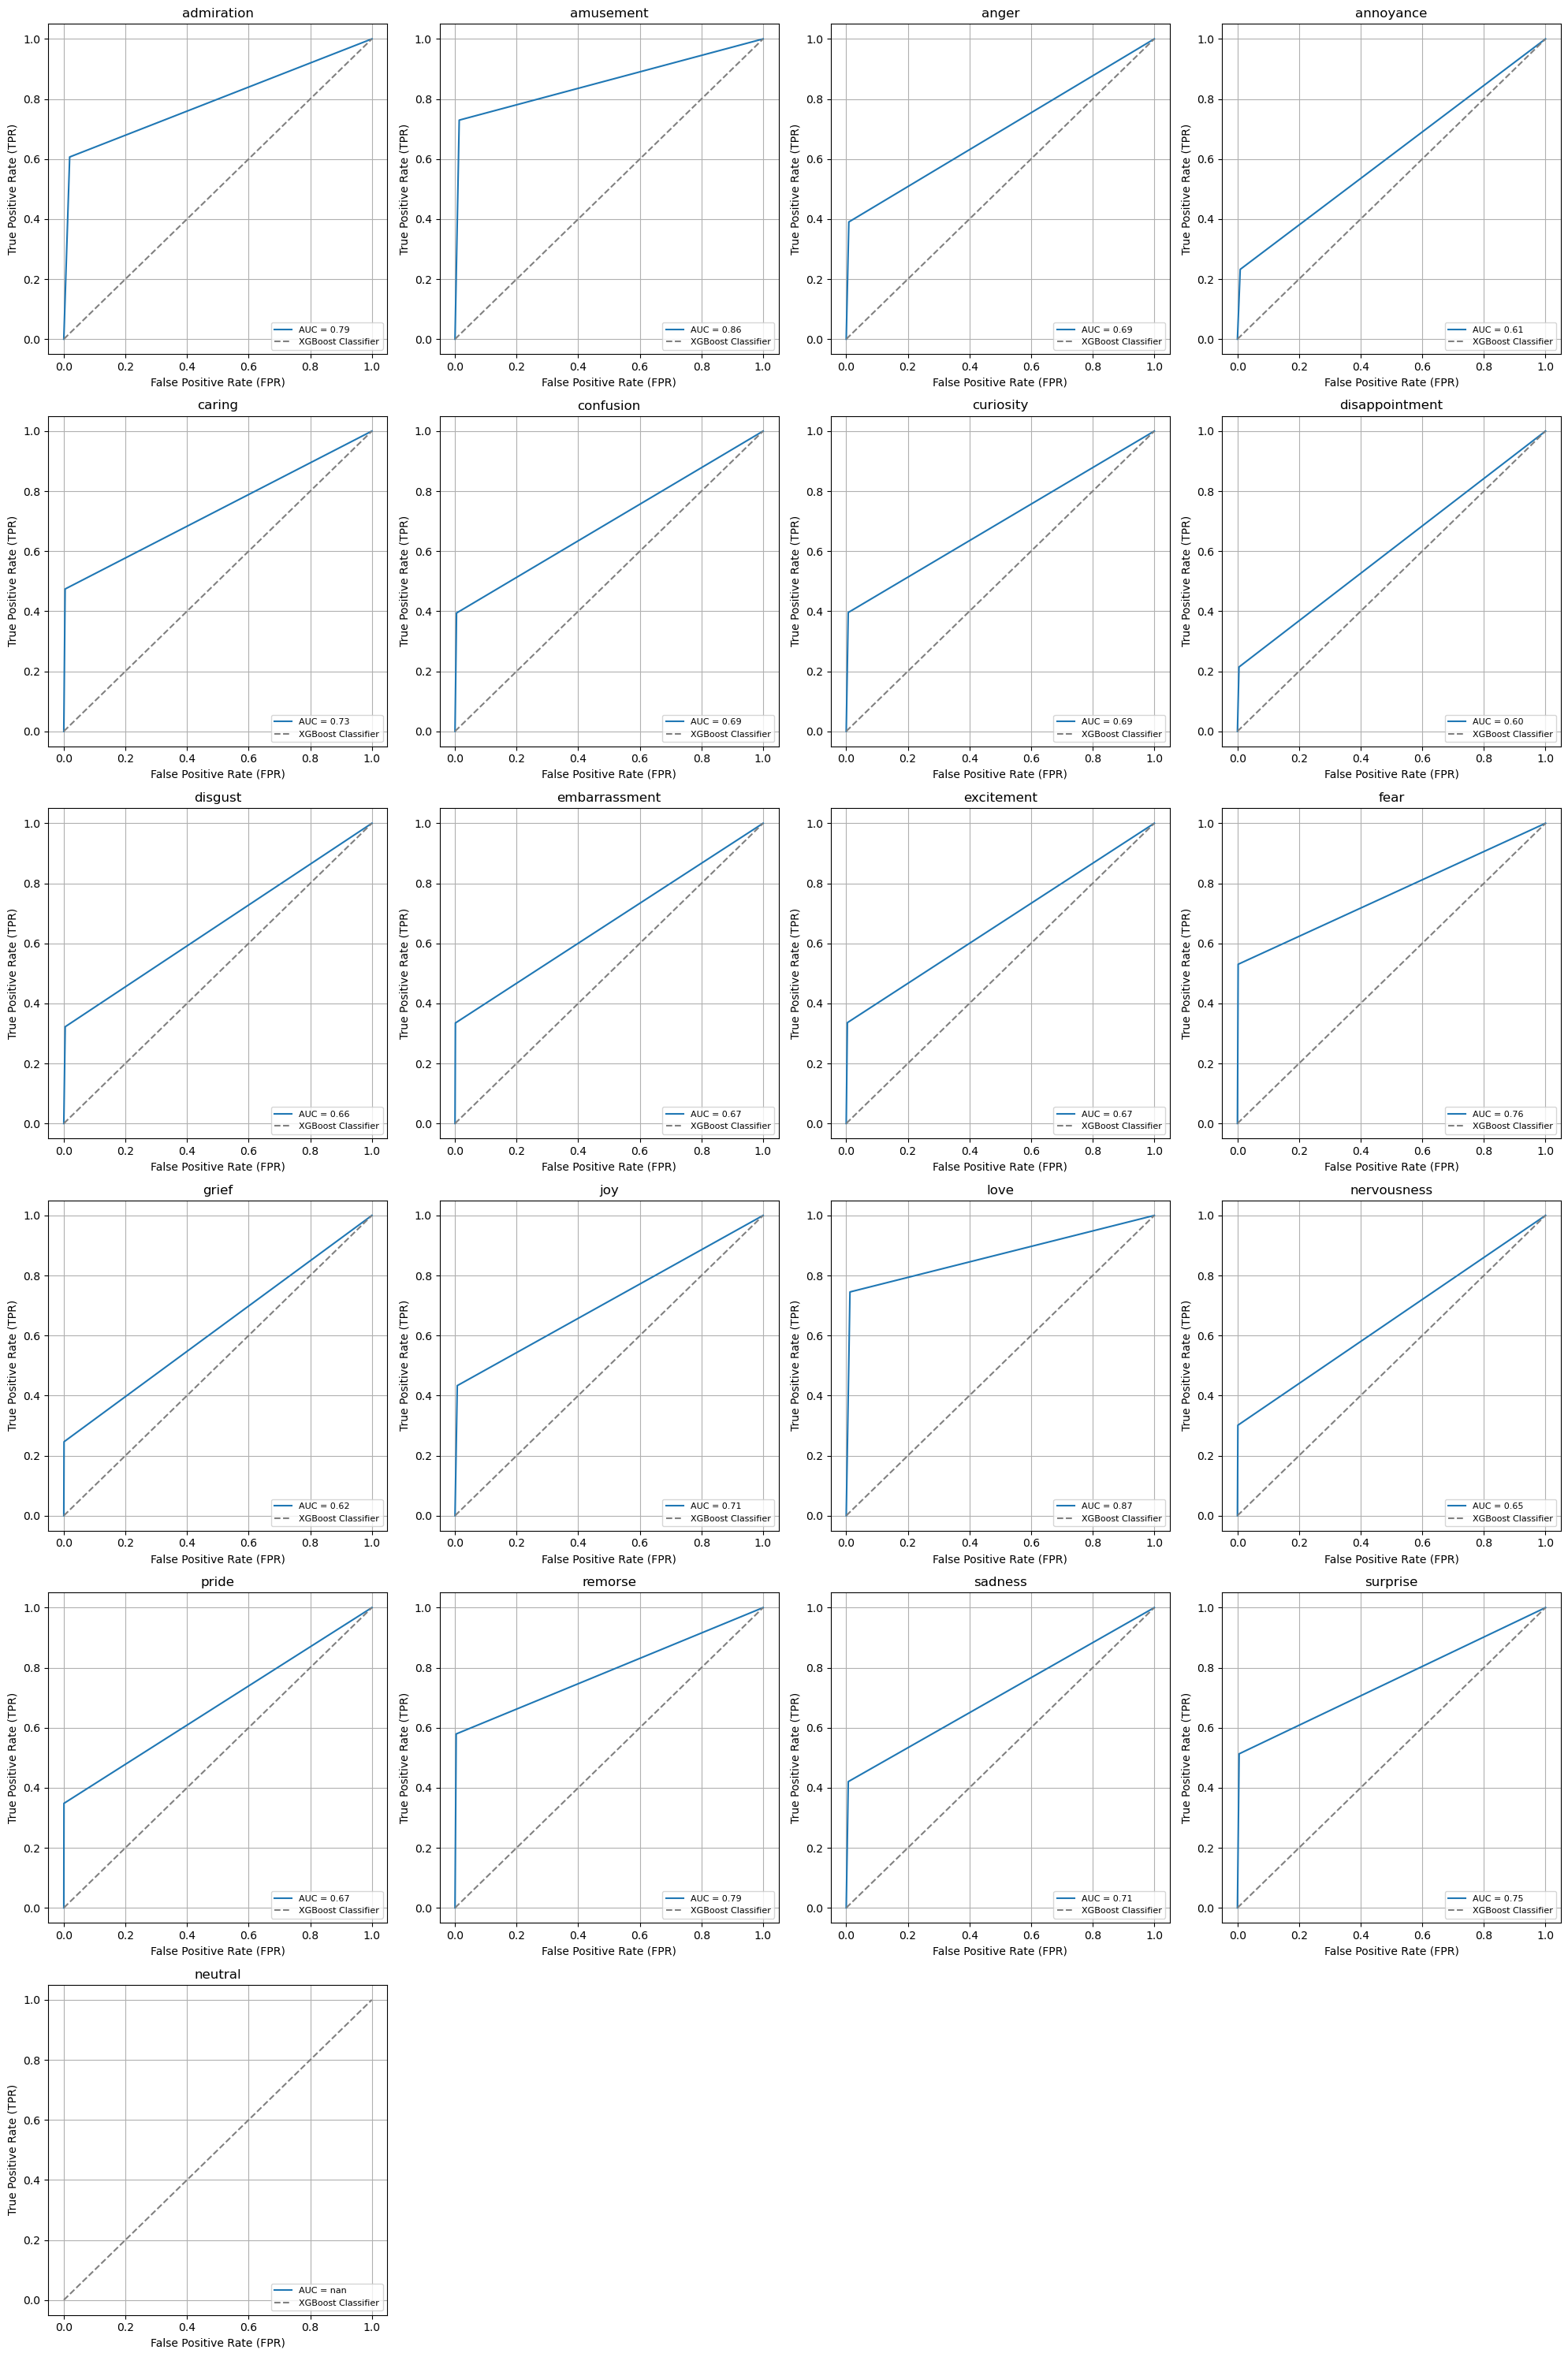

In [611]:

n_emotions = len(emotion_columns)
n_cols = 4 
n_rows = int(np.ceil(n_emotions / n_cols))  

plt.figure(figsize=(20, 5 * n_rows))

for i, emotion in enumerate(emotion_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_pred_xgb[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="XGBoost Classifier")
    
    plt.title(f"{emotion}", fontsize=12)
    plt.xlabel("False Positive Rate (FPR)", fontsize=10)
    plt.ylabel("True Positive Rate (TPR)", fontsize=10)
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.show()

Interpretation of the above ROC Curve: this image reveals that the multi-label classification model is performing moderately well in predicting emotions. The AUC-ROC values in most subplots range from 0.6 to 0.8. its better than random guessing. 

# Comparison Logistic Regression vs XGBoost 

In [ ]:
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score


y_pred_xgb = xgb.predict(X_test)
y_pred_log = log_reg.predict(X_test)


print("XGBoost Evaluation ")
acc_xgb = accuracy_score(y_test, y_pred_xgb)
hamming_xgb = hamming_loss(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='macro', zero_division=0)
recall_xgb = recall_score(y_test, y_pred_xgb, average='macro', zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, average='macro', zero_division=0)

print(f"Accuracy:        {acc_xgb:.4f}")
print(f"Hamming Loss:    {hamming_xgb:.4f}")
print(f"Precision (macro): {precision_xgb:.4f}")
print(f"Recall (macro):    {recall_xgb:.4f}")
print(f"F1-score (macro):  {f1_xgb:.4f}")
print("-" * 40)


print("Logistic Regression Evaluation ")
acc_log = accuracy_score(y_test, y_pred_log)
hamming_log = hamming_loss(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log, average='macro', zero_division=0)
recall_log = recall_score(y_test, y_pred_log, average='macro', zero_division=0)
f1_log = f1_score(y_test, y_pred_log, average='macro', zero_division=0)

print(f"Accuracy:        {acc_log:.4f}")
print(f"Hamming Loss:    {hamming_log:.4f}")
print(f"Precision (macro): {precision_log:.4f}")
print(f"Recall (macro):    {recall_log:.4f}")
print(f"F1-score (macro):  {f1_log:.4f}")


XGBoost Evaluation 
Accuracy:        0.4077
Hamming Loss:    0.0365
Precision (macro): 0.7797
Recall (macro):    0.4069
F1-score (macro):  0.5223
----------------------------------------
Logistic Regression Evaluation 
Accuracy:        0.1288
Hamming Loss:    0.0524
Precision (macro): 0.4293
Recall (macro):    0.1038
F1-score (macro):  0.1479


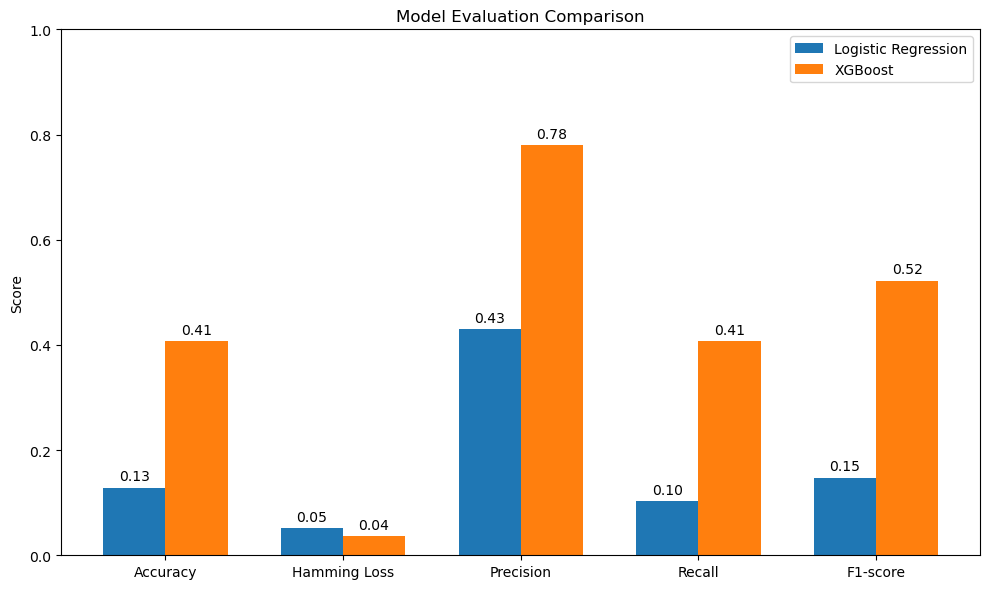

In [ ]:
metrics = ['Accuracy', 'Hamming Loss', 'Precision', 'Recall', 'F1-score']
xgb_scores = [acc_xgb, hamming_xgb, precision_xgb, recall_xgb, f1_xgb]
log_scores = [acc_log, hamming_log, precision_log, recall_log, f1_log]


x = np.arange(len(metrics)) 
width = 0.35  


fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, log_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, xgb_scores, width, label='XGBoost')


ax.set_ylabel('Score')
ax.set_title('Model Evaluation Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)  


def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


Interpretation of the comparison Bar: This bar chart provides a clear comparison of Logistic Regression and XGBoost model performance across six key metrics: Accuracy, Hamming Loss, ROC-AUC (Macro), Precision (Macro), Recall (Macro), and F1-Score (Macro).  Notably, XGBoost consistently outperforms Logistic Regression in nearly all categories, demonstrating significantly higher values for Accuracy, ROC-AUC, Precision, Recall, and F1-Score, while also achieving a slightly lower Hamming Loss. These results strongly suggest that XGBoost is the superior model choice for this multi-label classification task, showcasing its ability to capture complex patterns and deliver more accurate predictions compared to Logistic Regression.



In [622]:
import joblib
joblib.dump(xgb, "model.joblib")
joblib.dump(tfidf_vectorizer, "vectorizer.joblib")
joblib.dump(svd_model, "svd_model.joblib")
joblib.dump(emotion_columns, "emotion_columns.joblib")


['emotion_columns.joblib']

In [638]:
import requests


url = "https://ml-api-1055958174760.us-central1.run.app/predict"


headers = {
    "Content-Type": "application/json",
    "x-api-key": "my-super-secret-api-key-2025"
}


payload = {
    "input": [
        "I am sad and disappointed.",
        "You are amazing!",
        "That was really exciting!",
        "I feel so embarrassed and nervous.",
        "This is disgusting!"
    ]
}


response = requests.post(url, json=payload, headers=headers)


if response.status_code == 200:
    predictions = response.json().get("prediction", [])
    for text, emotions in zip(payload["input"], predictions):
        print(f"Text: {text}")
        print(f"Predicted Emotions: {emotions}")
        print("------")
else:
    print("Error:", response.status_code)
    print(response.text)


Text: I am sad and disappointed.
Predicted Emotions: ['disappointment', 'sadness']
------
Text: You are amazing!
Predicted Emotions: ['admiration']
------
Text: That was really exciting!
Predicted Emotions: ['admiration']
------
Text: I feel so embarrassed and nervous.
Predicted Emotions: ['disappointment', 'nervousness', 'sadness']
------
Text: This is disgusting!
Predicted Emotions: ['annoyance', 'disgust']
------
